In [3]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/news/

Mounted at /content/drive
/content/drive/MyDrive/news


In [29]:
import pandas as pd
import numpy as np
from numpy import array
import nltk
from nltk.corpus import stopwords
import re
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from numpy import asarray
from numpy import zeros
from keras.layers import LSTM, Embedding
from keras.models import Sequential
from keras.layers.core import Dense
import matplotlib.pyplot as plt

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
imdb_reviews = pd.read_csv("imdb_reviews.csv")
# safety check
imdb_reviews.shape

(50000, 2)

preprocessing

In [6]:
def preprocess(s):
    s = s.lower()

    s = re.compile(r'<[^>]+>').sub('', s)

    # remove punctuations/numbers
    s = re.sub('[^a-zA-Z]', ' ', s)

    # remove single letters
    s = re.sub(r"\s+[a-zA-Z]\s+", ' ', s)

    # remove places with more than one space
    s = re.sub(r'\s+', ' ', s)

    # remove nltk stopwords (regex makes it go wayyy faster than the line below)
    # s = ' '.join([word for word in s.split() if word not in (stopwords.words('english'))])
    s = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*').sub('', s)

    return s

In [7]:
print(preprocess("i use ` rust for BLLLLLAZINGLY fast code    ... its amazing"))

use rust blllllazingly fast code amazing


In [8]:
# preprocessing all reviews
preprocessed_text = []

for review in list(imdb_reviews['review']):
    preprocessed_text.append(preprocess(review))

print(preprocessed_text[1])

wonderful little production filming technique unassuming old time bbc fashion gives comforting sometimes discomforting sense realism entire piece actors extremely well chosen michael sheen got polari voices pat truly see seamless editing guided references williams diary entries well worth watching terrificly written performed piece masterful production one great master comedy life realism really comes home little things fantasy guard rather use traditional dream techniques remains solid disappears plays knowledge senses particularly scenes concerning orton halliwell sets particularly flat halliwell murals decorating every surface terribly well done 


In [10]:
# converting each review's "sentiment" column value to 1 and 0 instead of "positive" and "negative"
sentiments = []

for sentiment in imdb_reviews['sentiment']:
    if sentiment == "positive":
        sentiments.append(1)
    else:
        sentiments.append(0)

sentiments = np.array(sentiments)

print(sentiments[1])

1


In [11]:
# spliting data into training and test set data for the model
X_train, X_test, y_train, y_test = train_test_split(preprocessed_text, sentiments, test_size=0.25, random_state=42)

making embedded layer

In [12]:
# transform raw text into numerical representations suitable for feeding into the model
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [13]:
# our corpus has 90,094 words in it
# also adding one more to the mix for words that dont have a word embedding (90,095 total)
corpus_length = len(tokenizer.word_index) + 1
print(corpus_length)

90095


In [15]:
# padding reviews to 100 tokens
X_train = pad_sequences(X_train, padding='post', maxlen=100)
X_test = pad_sequences(X_test, padding='post', maxlen=100)

In [17]:
# creating dict that will contain word embeddings for words found in the glove_word_embeddings.txt
word_embeddings_dict = {}
glove_word_embeddings = open('glove_word_embeddings.txt', encoding="utf8")

for line in glove_word_embeddings:
    values = line.split()
    word = values[0]
    embedding_vector = np.asarray(values[1:], dtype='float32')
    word_embeddings_dict[word] = embedding_vector
glove_word_embeddings.close()

In [18]:
# each row corresponds to the index of the word in the corpus
# the matrix has 100 columns, where each column contains the glove embeddings for the words in the corpus
# matrix can now be used as an initial embedding layer when training the neural network
embedding_matrix = np.zeros((corpus_length, 100))

for word, i in tokenizer.word_index.items():
    embedding_vector = word_embeddings_dict.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [20]:
print(embedding_matrix.shape)

(90095, 100)


training

In [24]:
# setup for a sequential model using our word embeddings and LSTM layer, followed by a final dense layer for binary classification output
model = Sequential()
model.add(Embedding(corpus_length, 100, weights=[embedding_matrix], input_length=100, trainable=False))
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))

In [25]:
# compile
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          9009500   
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 9,126,877
Trainable params: 117,377
Non-trainable params: 9,009,500
_________________________________________________________________
None


In [26]:
# trainingggg
fit_model = model.fit(X_train, y_train, batch_size=512, epochs=6, verbose=1, validation_split=0.20)

Epoch 1/6
59/59 [==============================] - 74s 1s/step - loss: 0.5734 - accuracy: 0.6912 - val_loss: 0.4645 - val_accuracy: 0.7927
Epoch 2/6
59/59 [==============================] - 69s 1s/step - loss: 0.4529 - accuracy: 0.7921 - val_loss: 0.4422 - val_accuracy: 0.7937
Epoch 3/6
59/59 [==============================] - 68s 1s/step - loss: 0.4199 - accuracy: 0.8088 - val_loss: 0.3969 - val_accuracy: 0.8247
Epoch 4/6
59/59 [==============================] - 68s 1s/step - loss: 0.3917 - accuracy: 0.8233 - val_loss: 0.3801 - val_accuracy: 0.8289
Epoch 5/6
59/59 [==============================] - 67s 1s/step - loss: 0.3711 - accuracy: 0.8367 - val_loss: 0.3860 - val_accuracy: 0.8380
Epoch 6/6
59/59 [==============================] - 66s 1s/step - loss: 0.3606 - accuracy: 0.8422 - val_loss: 0.3591 - val_accuracy: 0.8405


In [28]:
# final results
print(model.evaluate(X_test, y_test, verbose=1))

391/391 [==============================] - 25s 64ms/step - loss: 0.3711 - accuracy: 0.8398
[0.3711261451244354, 0.8398399949073792]


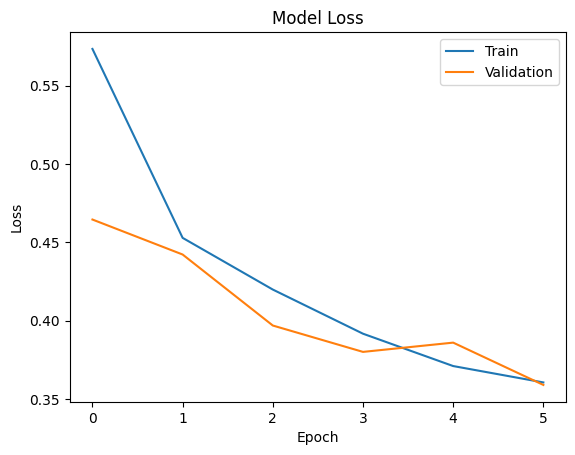

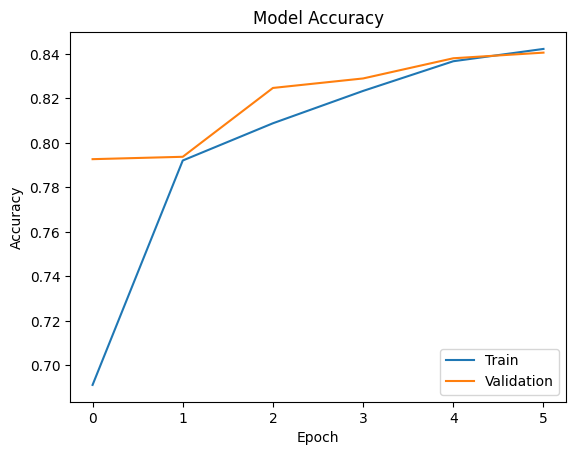

In [30]:
# plot training and validation loss values
plt.plot(fit_model.history['loss'])
plt.plot(fit_model.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# plot training and validation accuracy values
plt.plot(fit_model.history['accuracy'])
plt.plot(fit_model.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

In [31]:
# save
model.save("./model.h5", save_format='h5')

testing samples

In [46]:
test_reviews = pd.read_csv("imdb_test_reviews.csv")

test_preprocessed = []
for review in test_reviews["Review Text"]:
  review = preprocess(review)
  test_preprocessed.append(review)

# tokenising with tokenizer from before
test_tokenized = tokenizer.texts_to_sequences(test_preprocessed)

# padding to 100 tokens
test_padded = pad_sequences(test_tokenized, padding='post', maxlen=100)

# passing tokenized + padded reviews to the model
test_sentiments = model.predict(test_padded)

print(test_sentiments)

1/1 [==============================] - 0s 33ms/step
[[0.70322126]
 [0.9763698 ]
 [0.25916782]
 [0.7369284 ]
 [0.9769013 ]
 [0.08849256]]


In [47]:
test_reviews['Predicted Rating'] = np.round(test_sentiments * 10, 1)
test_reviews.head(6)

,Unnamed: 0,Movie,Review Text,IMDb Rating,Predicted Rating
0,0,Ex Machina,Intelligent Movie.\nThis movie is obviously al...,9,7.0
1,1,Ex Machina,Extraordinary and thought-provoking.\n'Ex mach...,10,9.8
2,2,Ex Machina,"Poor story, only reasonable otherwise.\nIf I h...",3,2.6
3,3,Ex Machina,Had Great Potential.\nThis movie is one of the...,1,7.4
4,4,Eternals,Amazing visuals and philosophical concepts!\n\...,10,9.8
5,5,Eternals,Worst MCU film ever\n\nFollowing the events of...,3,0.9
